# Problem C: Image Generation

In [ ]:
# Install the required packages, not necessary if you already have them
%pip install lightning warmup-scheduler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.3 MB/s eta 0:00:00


In [ ]:
# built-in packages
import os
import math
import random
from IPython.display import display
from ipywidgets import Output

# third-party packages
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision.transforms import transforms
from torchvision.datasets import MNIST, Food101
from warmup_scheduler import GradualWarmupScheduler
from PIL import Image

# PyTorch Lightning
import lightning.pytorch as pl
from lightning.pytorch import LightningModule, Trainer
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor

In [ ]:
def seed_context(func):
    def wrapper(*args, seed=None, **kwargs):
        py_state = random.getstate()
        np_state = np.random.get_state()
        torch_state = torch.random.get_rng_state()
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
        result = func(*args, **kwargs)
        random.setstate(py_state)
        np.random.set_state(np_state)
        torch.random.set_rng_state(torch_state)
        return result

    return wrapper


def display_sample(image, widget):
    with widget:
        display(image, clear=True)

In [ ]:
class StackedMNIST(data.Dataset):
    @seed_context
    def __init__(self, mnist1, mnist2, mnist3, max_samples=240_000):
        self.mnist1 = mnist1
        self.mnist2 = mnist2
        self.mnist3 = mnist3
        self.len1 = len(mnist1)
        self.len2 = len(mnist2)
        self.len3 = len(mnist3)
        self.max_samples = max_samples
        self.idx1 = np.random.choice(self.len1, self.max_samples)
        self.idx2 = np.random.choice(self.len2, self.max_samples)
        self.idx3 = np.random.choice(self.len3, self.max_samples)
        self.pad_idx1 = np.random.choice(5, (self.max_samples, 2))
        self.pad_idx2 = np.random.choice(5, (self.max_samples, 2))
        self.pad_idx3 = np.random.choice(5, (self.max_samples, 2))

    def __len__(self):
        return self.max_samples

    def __getitem__(self, idx):
        img1, label1 = self.mnist1[self.idx1[idx]]
        img2, label2 = self.mnist2[self.idx2[idx]]
        img3, label3 = self.mnist3[self.idx3[idx]]

        # random pad to 32x32
        pad1 = self.pad_idx1[idx]
        pad2 = self.pad_idx2[idx]
        pad3 = self.pad_idx3[idx]
        img1 = F.pad(img1, (4, 4, 4, 4), mode="replicate")[
            :, pad1[0] : pad1[0] + 32, pad1[1] : pad1[1] + 32
        ]
        img2 = F.pad(img2, (4, 4, 4, 4), mode="replicate")[
            :, pad2[0] : pad2[0] + 32, pad2[1] : pad2[1] + 32
        ]
        img3 = F.pad(img3, (4, 4, 4, 4), mode="replicate")[
            :, pad3[0] : pad3[0] + 32, pad3[1] : pad3[1] + 32
        ]

        img = torch.cat([img1, img2, img3], dim=0)
        label = label1 * 100 + label2 * 10 + label3
        return img, label

In [ ]:
def process(x):
    return x * 2 - 1


def load_mnist_dataset(train=True, resize=None):
    transform_stack = [transforms.ToTensor(), transforms.Lambda(process)]
    if resize:
        transform_stack.insert(0, transforms.Resize(resize))
        if train:
            transform_stack.insert(1, transforms.RandomCrop(resize, padding=4))
    transform = transforms.Compose(transform_stack)
    dataset = MNIST(root="data", train=train, download=True, transform=transform)
    return dataset


def load_stacked_mnist_dataset(train=True, resize=None, max_samples=600_000, seed=42):
    mnist1 = load_mnist_dataset(train=train, resize=resize)
    mnist2 = load_mnist_dataset(train=train, resize=resize)
    mnist3 = load_mnist_dataset(train=train, resize=resize)
    dataset = StackedMNIST(mnist1, mnist2, mnist3, max_samples=max_samples, seed=seed)
    return dataset


def load_food101_dataset(train=True, resize=64):
    transform_stack = [transforms.ToTensor(), transforms.Lambda(process)]
    if resize:
        transform_stack.insert(0, transforms.Resize(resize))
        if train:
            transform_stack.insert(1, transforms.RandomCrop(resize))
        else:
            transform_stack.insert(1, transforms.CenterCrop(resize))
    transform = transforms.Compose(transform_stack)
    dataset1 = Food101(root="data", split="train", download=True, transform=transform)
    dataset2 = Food101(root="data", split="test", download=True, transform=transform)
    return data.ConcatDataset([dataset1, dataset2])

# Dataset Introduction

## MNIST Dataset
The MNIST dataset is a classic benchmark in machine learning, consisting of 28x28 grayscale handwritten digits (0-9).

- Training set: 60,000 images
- Test set: 10,000 images
- Image size: 28x28 pixels (1 channel)
- Pixel values: Normalized to [-1, 1] in our preprocessing

## Food101 Dataset
Food101 dataset contains 101 different classes of food, each class have 1000 images (train+test).

- Each image has 3 channels (equivalent to RGB)
- 101,000 samples (train+test)
- high resolution (maximum side length=512)
   - 5GB to download, may require few minutes
- will be resize-crop to 64x64 for our project

## StackedMNIST Dataset
StackedMNIST is a modified version that combines three MNIST digits into a single image by stacking them as channels. This creates a more complex dataset with the following properties:

- Each image has 3 channels (equivalent to RGB)
- Each channel contains a different MNIST digit
- Labels are 3-digit numbers (e.g., if channel 1 is '4', channel 2 is '2', and channel 3 is '7', the label is 427)
- Total possible combinations: 1000 (10³) different classes
- Maximum samples: 240,000 (configurable in the dataset)

### Key Features of Our Implementation:
1. **Preprocessing**:
   - Images are normalized to [-1, 1] range using the `process` function
   - Optional resizing and random cropping for training augmentation

2. **Data Loading**:
   - Both datasets use PyTorch's DataLoader for efficient batch processing
   - StackedMNIST uses random sampling with a seed for reproducibility
   - Each StackedMNIST sample is created by randomly combining three MNIST images

3. **Usage with VAE**:
   - For single MNIST: Input shape will be [B, 1, 28, 28]
   - For Food101: Input shape will be [B, 3, 64, 64]
   - For StackedMNIST: Input shape will be [B, 3, 32, 32]
   where B is the batch size

The StackedMNIST dataset provides a more challenging task for generative models, as they need to learn the relationships between three digits and generate coherent multi-channel images.

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.66MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 5.00G/5.00G [03:45<00:00, 22.2MB/s]


Extracting data/food-101.tar.gz to data


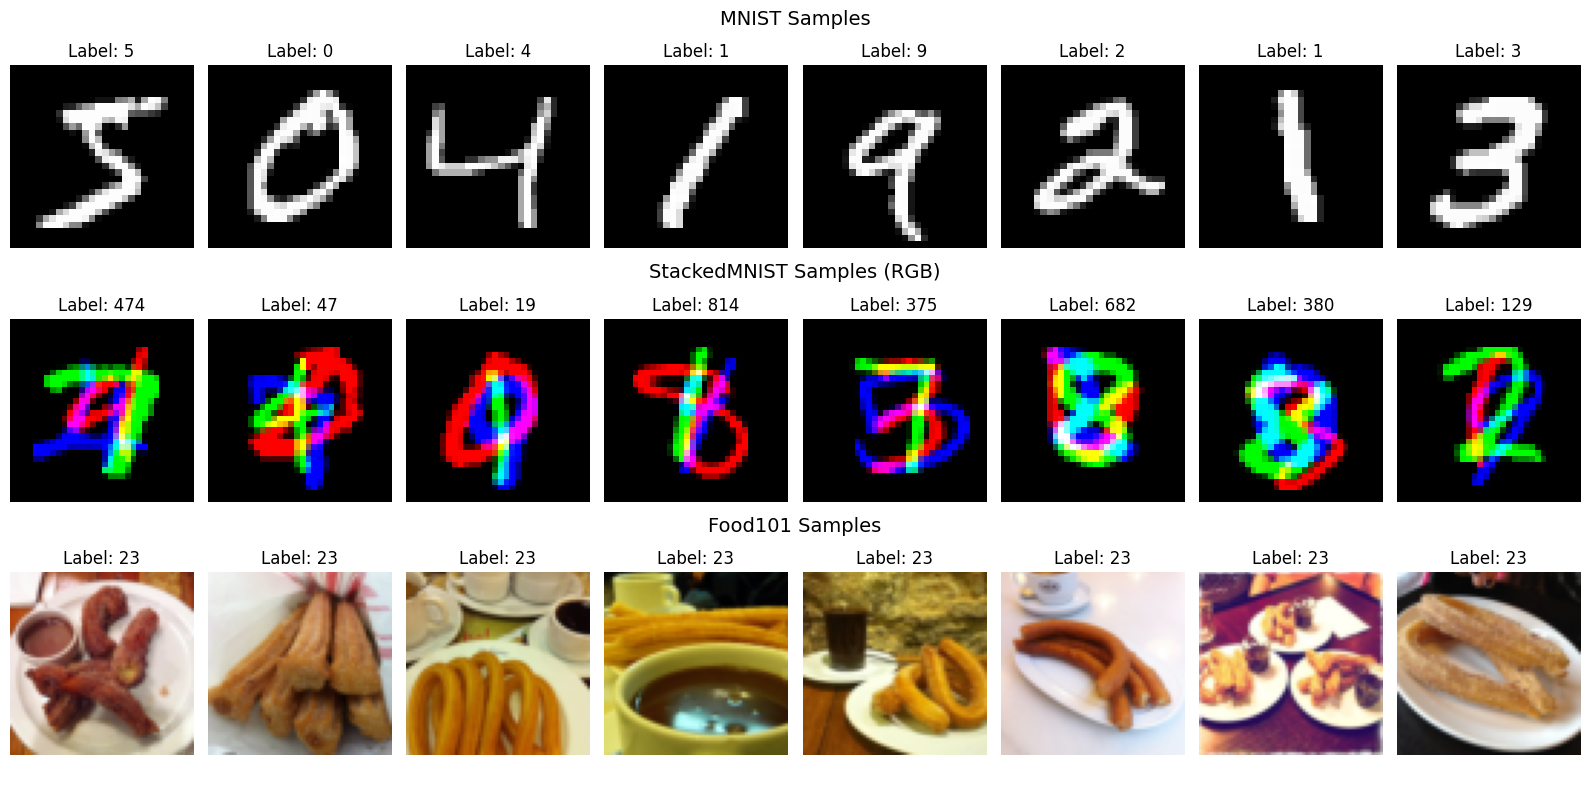

MNIST stats:
- Data shape: torch.Size([1, 28, 28])
- Labels range: 0-9
- Example labels: [5, 0, 4, 1, 9]

StackedMNIST stats:
- Data shape: torch.Size([3, 32, 32])
- Example labels: [474, 47, 19, 814, 375]
- Unique labels in first 100 samples: 95

Food101 stats:
- Data shape: torch.Size([3, 64, 64])
- Example labels: [23, 23, 23, 23, 23]
- Unique labels in first 100 samples: 1


In [ ]:
import matplotlib.pyplot as plt

# Visualize both MNIST and StackedMNIST
mnist_dataset = load_mnist_dataset(train=True)
stacked_dataset = load_stacked_mnist_dataset(train=True)
food101_dataset = load_food101_dataset(train=True)

# Create figure with two rows
plt.figure(figsize=(16, 8))

# First row: Regular MNIST
plt.subplot(3, 1, 1)
plt.axis("off")
plt.title("MNIST Samples", fontsize=14, pad=10)
for i in range(8):
    plt.subplot(3, 8, i + 1)
    img, label = mnist_dataset[i]
    plt.imshow(img[0].numpy() * 0.5 + 0.5, cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")

# Second row: StackedMNIST as RGB
plt.subplot(3, 1, 2)
plt.axis("off")
plt.title("StackedMNIST Samples (RGB)", fontsize=14, pad=10)
for i in range(8):
    plt.subplot(3, 8, i + 8 + 1)
    img, label = stacked_dataset[i]
    rgb_img = img.permute(1, 2, 0)  # Change from (C,H,W) to (H,W,C)
    plt.imshow(rgb_img.numpy() * 0.5 + 0.5)
    plt.title(f"Label: {label}")
    plt.axis("off")

# Third row: Food101
plt.subplot(3, 1, 3)
plt.axis("off")
plt.title("Food101 Samples", fontsize=14, pad=10)
for i in range(8):
    plt.subplot(3, 8, i + 16 + 1)
    img, label = food101_dataset[i]
    plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Print some statistics
mnist_samples = [mnist_dataset[i][1] for i in range(100)]
stacked_samples = [stacked_dataset[i][1] for i in range(100)]
food101_samples = [food101_dataset[i][1] for i in range(100)]
print("MNIST stats:")
print(f"- Data shape: {mnist_dataset[0][0].shape}")
print(f"- Labels range: 0-9")
print(f"- Example labels: {mnist_samples[:5]}")
print("\nStackedMNIST stats:")
print(f"- Data shape: {stacked_dataset[0][0].shape}")
print(f"- Example labels: {stacked_samples[:5]}")
print(f"- Unique labels in first 100 samples: {len(set(stacked_samples))}")
print("\nFood101 stats:")
print(f"- Data shape: {food101_dataset[0][0].shape}")
print(f"- Example labels: {food101_samples[:5]}")
print(f"- Unique labels in first 100 samples: {len(set(food101_samples))}")

## C1: VAE for MNIST

A VAE is a generative model that learns to encode data into a latent space and then decode it back. Unlike traditional autoencoders, VAEs enforce a probabilistic structure on the latent space, making it suitable for generation.

### Key Components:

1. **Encoder** ($q_\phi(z|x)$): Maps input $x$ to parameters of a latent distribution
   - Outputs mean $\mu$ and log variance $\log \sigma^2$ of the latent space
   - Models a normal distribution: $z \sim \mathcal{N}(\mu, \sigma^2)$

2. **Reparameterization Trick**: Makes the network differentiable
   $$z = \mu + \sigma \odot \epsilon, \text{ where } \epsilon \sim \mathcal{N}(0, I)$$

3. **Decoder** ($p_\theta(x|z)$): Reconstructs input from latent representation
   - Models the probability distribution of the input space
   - For images, often uses Bernoulli or Gaussian distributions

The overall objective is to maximize the evidence lower bound (ELBO):
$$\mathcal{L}(\theta, \phi; x) = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - D_{KL}(q_\phi(z|x) || p(z))$$

where $p(z)$ is typically a standard normal distribution $\mathcal{N}(0, I)$.

In [ ]:
class SimpleVAEForImage(nn.Module):
    def __init__(self, input_dim, hidden_size, latent_size=2):
        super().__init__()
        self.input_size = input_dim
        self.hidden_size = hidden_size
        self.latent_size = latent_size

        ### [Note]: to achieve VAE, your encoder should output 2x latent_size
        ### [Note]: the input is [B, input_dim, H, W], you may need to flatten it
        ### [Note]: you can use "ANY" arch here
        ## [TODO] BEGIN
        #self.encoder = nn.Sequential(
        #   nn.Flatten(),
        #   nn.Linear(784, hidden_size),
        #   nn.ReLU(),
        #   nn.Linear(hidden_size, 2 * latent_size),
        #)
        #self.decoder = nn.Sequential(
        #   nn.Linear(latent_size, hidden_size),
        #   nn.ReLU(),
        #   nn.Linear(hidden_size, 784),
        #   nn.Unflatten(1, (1, 28, 28)),
        #)
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2 * latent_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 784),
            nn.Tanh(),  # Since input is normalized to [-1, 1]
            nn.Unflatten(1, (1, 28, 28)),
        )
        ## [TODO] END

    def forward(self, x):
        mu, logvar = self.encoder(x).chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

    def reparameterize(self, mu, logvar):
        ## [TODO] BEGIN
        if self.training:
          std = torch.exp(0.5 * logvar)
          eps = torch.randn_like(std)
          temperature = 1.0
          return mu + temperature * std * eps
        return mu
        ## [TODO] END

### VAE Loss Terms

The VAE loss consists of two main components:

1. **Reconstruction Loss**: Measures how well the decoder reconstructs the input
   - For binary images (MNIST): Binary Cross Entropy
   - For continuous images: Mean Squared Error (MSE)
   $$\mathcal{L}_{recon} = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]$$

2. **KL Divergence Loss**: Ensures the latent distribution matches the prior
   - For normal distributions with diagonal covariance:
   $$\mathcal{L}_{KL} = D_{KL}(q_\phi(z|x) || p(z))$$
   $$= \frac{1}{2}\sum_{i=1}^d (\mu_i^2 + \sigma_i^2 - \log \sigma_i^2 - 1)$$

The total loss is their sum:
$$\mathcal{L}_{total} = \mathcal{L}_{recon} + \beta \mathcal{L}_{KL}$$

where $\beta$ is a hyperparameter (usually 1) that can be adjusted to control the trade-off between reconstruction quality and latent space regularity.

Note: In the implementation, we let the model to output `logvar` ($\log \sigma^2$) instead of $\sigma^2$ for numerical stability. <br>
Note2: remember to take average of kl divergence across each entry in batch.

In [ ]:
vae_display = Output()


class Vae(LightningModule):
    def __init__(
        self,
        input_size,
        hidden_size,
        latent_size,
        lr=1e-3,
        total_steps=1e6,
        warmup_steps=100,
        weight_decay=1e-3,
        log_period=100,
    ):
        super().__init__()
        self.model = SimpleVAEForImage(input_size, hidden_size, latent_size)
        self.lr = lr
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.weight_decay = weight_decay
        self.log_period = log_period

    def configure_optimizers(self):
        ## [TODO*] Customize your optimizer and scheduler definition
        ## Not required
        optimizer = optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, self.total_steps, self.lr / 100
        )
        if self.warmup_steps > 0:
            scheduler = GradualWarmupScheduler(
                optimizer,
                multiplier=1,
                total_epoch=self.warmup_steps,
                after_scheduler=scheduler,
            )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

    def sample(self, x):
        mu, logvar = self.model.encoder(x).chunk(2, dim=1)
        z = self.model.reparameterize(mu, logvar)
        return z

    def encode(self, x):
        return self.model.encoder(x).chunk(2, dim=1)[0]

    def decode(self, z):
        return self.model.decoder(z)

    def draw_sample(self, z_dim=2):
        z = torch.linspace(-3, 3, 28)
        z = torch.stack(torch.meshgrid([z] * z_dim)).reshape(2, -1).T
        z = z.to(self.device)
        with torch.no_grad():
            result = self.decode(z)
        result = (
            result.reshape(*[28] * z_dim, 28, 28).transpose(-3, -2).reshape(-1, 28 * 28)
        )
        result = (
            ((result * 0.5 + 0.5) * 255).clamp(0, 255).cpu().numpy().astype(np.uint8)
        )
        img = Image.fromarray(result)
        display_sample(img, vae_display)
        img.save("vae-sample.png")

    def training_step(self, batch, batch_idx):
        x, label = batch
        recon, mu, logvar = self.model(x)
        ### [Note]: recon loss will be pixel wise, kl loss will be sample wise
        ## [TODO] BEGIN
        recon_loss = F.mse_loss(recon, x, reduction="sum") / x.size(0)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
        loss = recon_loss + kl_loss
        loss = loss
        ## [TODO] END
        self.log("loss", loss, prog_bar=True)
        self.log("recon_loss", recon_loss, prog_bar=True)
        self.log("kl_loss", kl_loss, prog_bar=True)
        if self.global_step % self.log_period == 0:
            self.draw_sample()
        return loss

In [ ]:
## Realtime logging of VAE samples
## in vscode it will output duplicated images, but it works fine in jupyter notebook or colab
# display(vae_display)

In [ ]:
pl.seed_everything(42)
## [TODO] Hyperparameters
EPOCHS = 100
BATCH_SIZE = 128
HIDDEN_SIZE = 512
LR = 2e-3
WARMUP_STEPS = 100
WEIGHT_DECAY = 1e-3
# "gpu" for CUDA/ROCm, "tpu" for TPU.
# Both are supported on Colab (based on your machine)
# tpu may have some problem that first run will always failed (just rerun it)
ACCELERATOR = "gpu"

# Constant DONT TOUCH
LATENT_SIZE = 2
LOG_PERIOD = 100
SAVE_PERIOD = 1000
# Constant DONT TOUCH

## Loading Dataset
dataset = load_mnist_dataset(train=True)
train_loader = data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE // (8 if ACCELERATOR == "tpu" else 1),
    shuffle=True,
    ## Comment out for Windows ↓
    num_workers=4,
    persistent_workers=True,
)
train_epoch_size = len(train_loader) // (8 if ACCELERATOR == "tpu" else 1)
train_steps = train_epoch_size * EPOCHS

vae = Vae(
    input_size=1,
    hidden_size=HIDDEN_SIZE,
    latent_size=LATENT_SIZE,
    lr=LR,
    total_steps=train_steps,
    warmup_steps=WARMUP_STEPS,
    weight_decay=WEIGHT_DECAY,
    log_period=LOG_PERIOD,
)


trainer = Trainer(
    max_epochs=EPOCHS,
    accelerator=ACCELERATOR,
    precision="32-true" if ACCELERATOR == "tpu" else "16-mixed",
    callbacks=[
        LearningRateMonitor(logging_interval="step"),
        ModelCheckpoint(every_n_train_steps=SAVE_PERIOD, save_on_train_epoch_end=True),
    ],
    log_every_n_steps=1,
    gradient_clip_val=0.1,
)

trainer.fit(vae, train_loader)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.ra

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## C2: Guided Flow Matching Diffusion Model

Flow Matching is a novel approach to generative modeling that constructs trajectories between noise and data distributions using probability flow ODEs. Unlike traditional diffusion models that use a fixed noise schedule, flow matching learns the optimal path directly.
**But it is still a diffusion model in general**

### Key Components:

1. **Forward Process** ($p(x_t|x_0)$): Linear interpolation between data and noise
   - Maps input $x_0$ to noise $x_1$ via: $x_t = (1-t)x_0 + tx_1$
   - $t \in [0,1]$ represents the interpolation progress
   - $x_1 \sim \mathcal{N}(0, I)$ is random Gaussian noise

2. **Flow Model** ($f_\theta(x_t, t, c)$): Predicts the direction of data flow
   - Takes noisy sample $x_t$, time $t$, and condition $c$
   - Models the vector field of the probability flow ODE
   - Guided by class condition $c$ for controlled generation

3. **Sampling Process**: ODE solver with small steps
   - Starting from $x_1 \sim \mathcal{N}(0, I)$
   - Iterative update: $x_{t-dt} = x_t - dt \cdot f_\theta(x_t, t, c)$
   - Converges to a sample from target distribution at $t=0$

The model learns a continuous transformation between distributions through optimal transport, making the training more stable than traditional diffusion models.

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
        )

    def forward(self, x):
        return self.conv(x)

class SimpleDM(nn.Module):
    def __init__(self, input_dim, hidden_size, num_classes=101):
        super().__init__()
        self.input_size = input_dim
        self.hidden_size = hidden_size

        ### [Note]: This question require more complex model than SimpleVAEForImage
        ### [Note]: you can use "ANY" arch here
        ### [Note]: UNet or DiT can be useful here
        ## [TODO] BEGIN
        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
        )

        # Class embedding
        self.class_embed = nn.Embedding(num_classes, hidden_size)

        self.init_conv = nn.Conv2d(input_dim, hidden_size//4, 3, padding=1)

        # Encoder
        self.down1 = ConvBlock(hidden_size//4, hidden_size//2)
        self.down2 = ConvBlock(hidden_size//2, hidden_size)

        self.bottleneck = ConvBlock(hidden_size, hidden_size)

        # Decoder
        self.up2 = ConvBlock(hidden_size + hidden_size, hidden_size//2)
        self.up1 = ConvBlock(hidden_size//2 + hidden_size//4, hidden_size//4)

        # Output
        self.final_conv = nn.Conv2d(hidden_size//4, input_dim, 1)

        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        #self.model = ...
        ## [TODO] END

    def forward(self, x, t, c):
        ### [Note]: add condition embedding to input
        ### You can use concat or addition or anything you think it will work
        ## [TODO] BEGIN
        # Time and class embeddings
        t_emb = self.time_embed(t.view(-1, 1))
        c_emb = self.class_embed(c)
        cond = (t_emb + c_emb).view(-1, self.hidden_size, 1, 1)

        x1 = self.init_conv(x)

        # Encoder path
        x2 = self.down1(x1)
        x2_down = self.downsample(x2)

        x3 = self.down2(x2_down)
        x3_down = self.downsample(x3)

        h = self.bottleneck(x3_down + cond)

        # Decoder path
        h = self.upsample(h)
        h = torch.cat([h, x3], dim=1)
        h = self.up2(h)

        h = self.upsample(h)
        h = torch.cat([h, x1], dim=1)
        h = self.up1(h)

        return self.final_conv(h)  # [B, input_dim, H, W]
        ## [TODO] END

### Flow Matching Loss Terms

The Flow Matching loss consists of one main component - matching the predicted flow to the ideal flow direction:

1. **Flow Matching Loss**: Ensures the model predicts the correct flow direction
   - Given $x_t = (1-t)x_0 + tx_1$, the ideal flow is:
   $$v(x_t, t) = x_1 - x_0$$
   
   - The model predicts $f_\theta(x_t, t, c)$ and aims to match this flow:
   $$\mathcal{L}_{FM} = \mathbb{E}_{t \sim U[0,1], x_0, x_1} \left[ \|f_\theta(x_t, t, c) - v(x_t, t)\|_2^2 \right]$$

2. **Implementation Details**:
   - Sample uniform time: $t \sim U[0,1]$
   - Compute interpolated point: $x_t = (1-t)x_0 + tx_1$
   - Target flow: $v(x_t, t) = x_1 - x_0$
   - Loss: $\mathcal{L} = \|f_\theta(x_t, t, c) - v(x_t, t)\|_2^2$

Note: Unlike VAE or traditional diffusion models, Flow Matching has a simpler loss term because it directly optimizes the flow field. The conditioning information $c$ guides the flow direction without requiring additional loss terms.

In [ ]:
fm_display = Output()


class FlowDM(LightningModule):
    def __init__(
        self,
        input_size=1,
        img_size=64,
        num_classes=101,
        split_channel=False,
        hidden_size=256,
        lr=1e-3,
        total_steps=1e6,
        warmup_steps=100,
        weight_decay=1e-3,
        log_period=100,
    ):
        super().__init__()
        self.input_size = input_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.split_channel = split_channel
        self.model = SimpleDM(input_size, hidden_size, num_classes)
        self.lr = lr
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.weight_decay = weight_decay
        self.log_period = log_period

    def configure_optimizers(self):
        ## [TODO*] Customize your optimizer and scheduler definition
        ## Not required
        optimizer = optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, self.total_steps, self.lr / 100
        )
        if self.warmup_steps > 0:
            scheduler = GradualWarmupScheduler(
                optimizer,
                multiplier=1,
                total_epoch=self.warmup_steps,
                after_scheduler=scheduler,
            )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

    def sample(self, xt, t, c, dt):
        t = torch.as_tensor(t).to(xt)
        if t.ndim == 0:
            t = t.unsqueeze(0).repeat(xt.size(0), 1)
        ## [TODO] BEGIN
        model_pred = self.model(xt, t, c)
        pred = xt + model_pred * dt
        return pred
        ## [TODO] END

    def draw_sample(self, steps=32):
        shape = (self.input_size, self.img_size, self.img_size)
        xt = torch.randn(256, *shape).to(self.device)
        c = torch.randint(0, self.num_classes, (256,)).to(self.device)
        t = 1.0
        for _ in range(steps):
            with torch.no_grad():
                xt = self.sample(xt, t, c, -1 / steps)
            t -= 1 / steps
        result = (
            xt.reshape(16, 16, *shape)
            .transpose(1, -2)
            .reshape(16 * self.img_size, self.input_size, 16 * self.img_size)
        )
        if self.split_channel:
            result = result.reshape(-1, self.input_size * 16 * self.img_size)
        else:
            result = result.transpose(1, 2)

        if result.ndim ==3 and result.size(2) == 1:
            result = result.squeeze(2)
        result = (
            ((result * 0.5 + 0.5) * 255).clamp(0, 255).cpu().numpy().astype(np.uint8)
        )
        img = Image.fromarray(result)
        display_sample(img, fm_display)
        img.save("fm-sample.png")

    def training_step(self, batch, batch_idx):
        x0, label = batch
        x1 = torch.randn_like(x0)
        ### [Note]: you can use other random method for t, just make sure it's in [0, 1]
        ###         For example: logit distribution, uniform distribution, etc.
        ## [TODO] BEGIN
        # Sample random time steps
        t = torch.rand(x0.size(0)).to(x0)

        # Interpolate between x0 and x1
        xt = (1 - t.view(-1, 1, 1, 1)) * x0 + t.view(-1, 1, 1, 1) * x1

        # Calculate target (flow matching objective)
        model_target = x1 - x0  # Flow from x0 to x1
        model_pred = self.model(xt, t, label)

        # Calculate loss
        loss = F.mse_loss(model_pred, model_target)
        ## [TODO] END
        self.log("loss", loss, prog_bar=True)
        if self.global_step % self.log_period == 0:
            self.draw_sample()
        return loss

In [ ]:
## Uncomment this to display the samples
# display(fm_display)

In [ ]:
pl.seed_everything(42)
## [TODO] Hyperparameters
EPOCHS = 10
BATCH_SIZE = 32
HIDDEN_SIZE = 256
LR = 1e-3
WARMUP_STEPS = 100
WEIGHT_DECAY = 1e-3
# "gpu" for CUDA/ROCm, "tpu" for TPU.
# Both are supported on Colab (based on your machine)
# tpu may have some problem that first run will always failed (just rerun it)
ACCELERATOR = "gpu"

# Constant DONT TOUCH
LOG_PERIOD = 100
SAVE_PERIOD = 1000
# Constant DONT TOUCH

## Loading Dataset
dataset = load_mnist_dataset(train=True)
train_loader = data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE // (8 if ACCELERATOR == "tpu" else 1),
    shuffle=True,
    ## Comment out for Windows ↓
    num_workers=4,
    persistent_workers=True,
)
train_epoch_size = len(train_loader) // (8 if ACCELERATOR == "tpu" else 1)
train_steps = train_epoch_size * EPOCHS

fdm = FlowDM(
    input_size=1,
    img_size=28,
    num_classes=10,
    hidden_size=HIDDEN_SIZE,
    lr=LR,
    total_steps=train_steps,
    warmup_steps=WARMUP_STEPS,
    weight_decay=WEIGHT_DECAY,
    log_period=LOG_PERIOD,
)


trainer = Trainer(
    max_epochs=EPOCHS,
    accelerator=ACCELERATOR,
    precision="32-true" if ACCELERATOR == "tpu" else "16-mixed",
    callbacks=[
        LearningRateMonitor(logging_interval="step"),
        ModelCheckpoint(every_n_train_steps=SAVE_PERIOD, save_on_train_epoch_end=True),
    ],
    log_every_n_steps=1,
    gradient_clip_val=0.1,
)

trainer.fit(fdm, train_loader)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.ra

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## C-challenge: Stacked MNIST or Food101

In [ ]:
pl.seed_everything(42)
## [TODO] Hyperparameters
EPOCHS = 10
BATCH_SIZE = 128
HIDDEN_SIZE = 256
LR = 5e-4
WARMUP_STEPS = 100
WEIGHT_DECAY = 1e-3
# "gpu" for CUDA/ROCm, "tpu" for TPU.
# Both are supported on Colab (based on your machine)
# tpu may have some problem that first run will always failed (just rerun it)
ACCELERATOR = "gpu"

# Constant DONT TOUCH
LOG_PERIOD = 100
SAVE_PERIOD = 1000
# Constant DONT TOUCH

## Loading Dataset
## [TODO*] Choose one of advanced dataset
dataset = load_stacked_mnist_dataset(train=True)
#dataset = load_food101_dataset(train=True)

train_loader = data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE // (8 if ACCELERATOR == "tpu" else 1),
    shuffle=True,
    ## Comment out for Windows ↓
    num_workers=4,
    persistent_workers=True,
)
train_epoch_size = len(train_loader) // (8 if ACCELERATOR == "tpu" else 1)
train_steps = train_epoch_size * EPOCHS

## [TODO*] Use advanced configuration here
fdm = FlowDM(
    input_size=3,
    img_size=64, # 32 for stacked mnist
    num_classes=1000,
    split_channel=True,
    hidden_size=HIDDEN_SIZE,
    lr=LR,
    total_steps=train_steps,
    warmup_steps=WARMUP_STEPS,
    weight_decay=WEIGHT_DECAY,
    log_period=LOG_PERIOD,
)


trainer = Trainer(
    max_epochs=EPOCHS,
    accelerator=ACCELERATOR,
    precision="32-true" if ACCELERATOR == "tpu" else "16-mixed",
    callbacks=[
        LearningRateMonitor(logging_interval="step"),
        ModelCheckpoint(every_n_train_steps=SAVE_PERIOD, save_on_train_epoch_end=True),
    ],
    log_every_n_steps=1,
    gradient_clip_val=0.1,
)

trainer.fit(fdm, train_loader)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.ra

Training: |          | 0/? [00:00<?, ?it/s]

# Report

## Problem C1
![VAE](https://drive.google.com/uc?export=view&id=11mKBDnRdDOCrQKY5D0XhVZtiip1FugrW)

We can see that the sample generation of the VAE is clear for each digits and the transition from one digit to another is smooth.

## Problem C2
![FM](https://drive.google.com/uc?export=view&id=15WJTFufhRetPWqwInz1jkh3a6SsXXei0)

We can see that the sample generation of the Diffusion Model is clear for some digits, but some digits cannot be recognized, and we can see that the result is rougher than the one generated by the VAE.

## Challenges and Improvements
The main challenges I faced in this lab is definitely the resources problem. With the limited resources, I find it hard at times to generate a good result. It is also hard to define the model architecture because a simple mistake can lead to an OOM problem. For C1, it is pretty hard to define the loss function because I am not sure in what way should I average it. And, my model doesn't seem to work with BCE loss even for MNIST but it works with MSE loss function. For C2, there is no particular challenges but I think it is overall pretty complex to implement. For the challenge part, here is the sample generation that I manage to produce:
### Food101:
![Food101](https://drive.google.com/uc?export=view&id=1u4RVWD1ye7oOQNH0TCobBuh3ENdfsGdQ)
### Stacked MNIST:
![StackedMNIST](https://drive.google.com/uc?export=view&id=1Lu_pfaJ4llri7p0JHWETYVnUYpa_U9zX)

From the sample generation of the dataset, we can see that it resembles the dataset from afar, but if we were to pay attention and look closely, we can see that it is a mess. This is because the model is only trained for 10 epochs. I believe that training it for a higher epoch such as 20 or 25 will generate a better result, however I am currently limited with the amount of hours Google Colab is able to provide for the free GPU.

### Complex Model UNET
I have also tried to implement a UNET architecture, but unfortunately it failed to perform. There is something wrong in the way I implemented it, because it crashes and causes OOM after training it for a few epochs. It may require more research to implement this model correctly and I am also limited with the free GPU that Google Colab provides.

![Unet](https://drive.google.com/uc?export=view&id=1z4PbDleqhTp4ZPeo8mTMQFZkNLCzS22l)

This is the image that the UNET model generated for the MNIST dataset after the 3rd epoch before causing the OOM problem. It is still far from generating a MNIST digit, but we can see that it is starting to capture the pattern of the MNIST digits. I believe that after implementing it correctly, it can also be used on the Food101 and StackedMNIST dataset to generate a better image than my current model.